In [144]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model, to_categorical   
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [145]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# days start interval
SURVIVAL_CATEGORIES= {
    'SHORT' : 0 , # 0-300
    'MEDIUM' : 250,  # 300-450
    'LONG' : 450, # 450 and more
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='C:/Users/HP/OneDrive/Desktop/BTP/MICCAI_BraTS2020_TrainingData/'

In [146]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

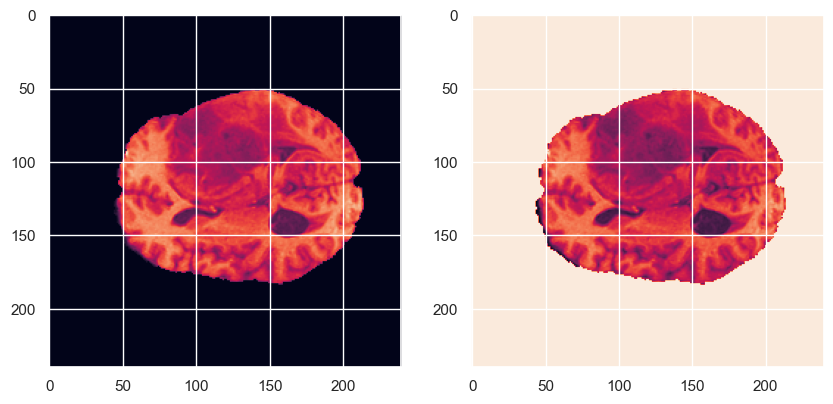

In [147]:
my_loc_slice=73
image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz').get_fdata()
my_img=image_volume[:,:,my_loc_slice]
my_converted_img = my_img.copy()
my_converted_img[my_converted_img == 0] = 666


f, axarr = plt.subplots(1,2, figsize = (10, 5))
axarr[0].imshow(my_img)
axarr[1].imshow(my_converted_img)

In [148]:
def maskSizeForSlice(path,i_slice):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    image_volume=nib.load(path).get_fdata()
    # flatten 3D image into 1D array and convert mask 4 to 2
    arr=image_volume[:,:,i_slice].flatten()
    arr[arr == 4] = 3

    unique, counts = np.unique(arr, return_counts=True)
    unique = unique.astype(int)
    values_dict=dict(zip(unique, counts))
    for k in range(1,4):
        totals[k] += values_dict.get(k,0)
    return totals

count class 1: 287
{1: 287, 2: 3843, 3: 631}


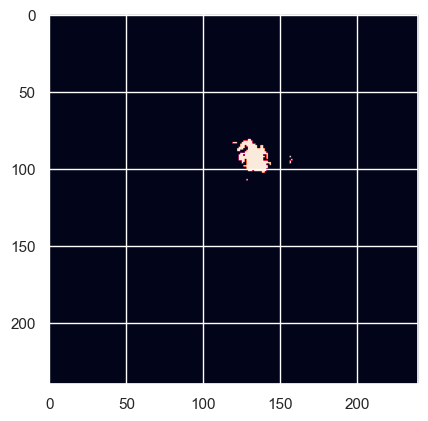

In [149]:
my_loc_slice=73
my_loc_class=1
seg_sum=maskSizeForSlice(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz',my_loc_slice)


image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz').get_fdata()
image_loc=image_volume[:,:,my_loc_slice]
image_loc[image_loc != my_loc_class] = 0

# plot segment only for class 'my_loc_class'
plt.imshow(image_loc)

image_loc=image_loc.flatten()
count = np.count_nonzero(image_loc == my_loc_class)
print(f'count class {my_loc_class}: {count}')
print(seg_sum)

In [150]:
import csv

csv_path = r'C:\Users\HP\OneDrive\Desktop\BTP\MICCAI_BraTS2020_TrainingData\survival_info.csv'

age_dict = {}
days_dict = {}


with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
  #  row_count = sum(1 for row in csv_reader)
 #   print(f'total rows: {row_count} .')
    at_line = 0
    category_short = 0
    category_medium = 0
    category_long = 0
    max_days = 0
    for row in csv_reader:
        if at_line == 0:
            print(f'Column names are {", ".join(row)}')
            at_line += 1
        else:
            if (row[3] != "GTR"):
                continue
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            if (not days.isnumeric()):
                continue
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                category_short += 1
            elif (int(days) >= 250 and int(days) <= 450):
                category_medium += 1
            else:
                category_long += 1
            at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
['BraTS20_Training_021', '56.921', '576', 'GTR']
['BraTS20_Training_022', '44.162', '350', 'GTR']


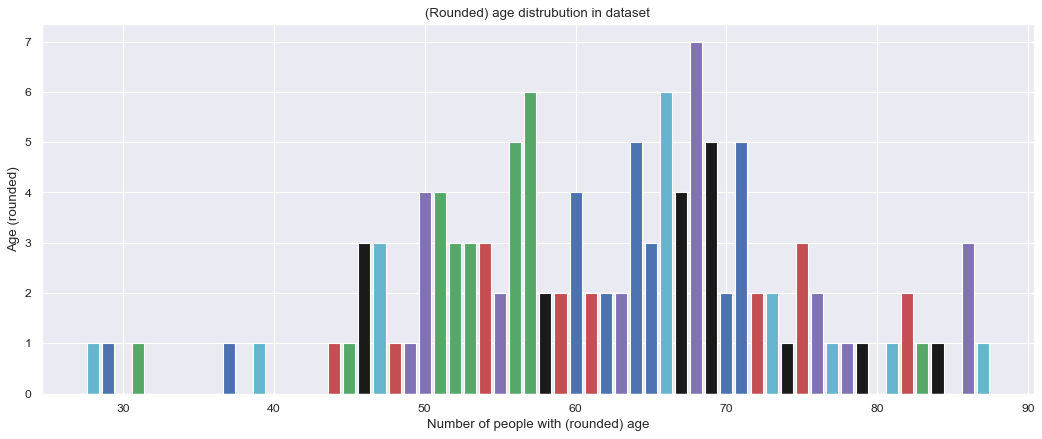

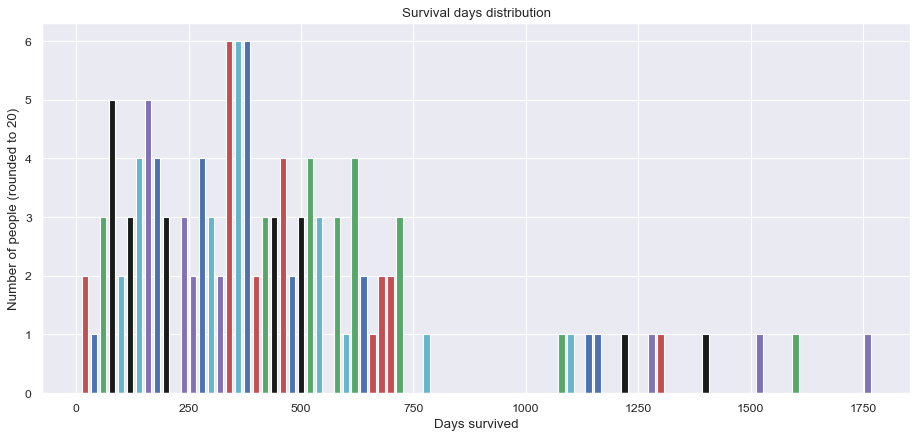

In [151]:
from collections import Counter
from itertools import cycle
#age_dict, days_dict 

# round values in dictionary
age_dict_rounded = {key : round(age_dict[key], 0) for key in age_dict}
# survival days are very distinct values => move the values in ranges per 20
days_dict_rounded = {key : round(days_dict[key]/20)*20 for key in days_dict}

# count same numbers => create statistics how many times is there person with same age
age_dict_rounded_counted = Counter(age_dict_rounded.values())
days_dict_rounded_counted = Counter(days_dict_rounded.values())

cycol = cycle('bgrcmk')
colors = list()
for i in range(len(age_dict_rounded_counted)):
    colors.append(next(cycol))
    
cycol = cycle('bgrcmk')    
colorsDays = list()
for i in range(len(days_dict_rounded_counted)):
    colorsDays.append(next(cycol))

plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Number of people with (rounded) age')
plt.ylabel('Age (rounded)')
plt.title("(Rounded) age distrubution in dataset")
plt.bar(list(age_dict_rounded_counted.keys()), age_dict_rounded_counted.values(), color=colors)
plt.show()

plt.figure(figsize=(14, 6), dpi=80)
plt.xlabel('Days survived')
plt.ylabel('Number of people (rounded to 20)')
plt.title("Survival days distribution")
plt.bar(list(days_dict_rounded_counted.keys()), days_dict_rounded_counted.values(),width=15, color=colorsDays)
plt.show()

In [152]:
# get number of pixels for each segment as dictionary
# original images contain segment values (0,1,2,4) => 4 is our 3 ... :)
def getMaskSizesForVolume(image_volume):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    for i in range(VOLUME_SLICES):
        # flatten 2D image into 1D array and convert mask 4 to 2
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        arr[arr == 4] = 3
        
        unique, counts = np.unique(arr, return_counts=True)
        unique = unique.astype(int)
        values_dict=dict(zip(unique, counts))
        for k in range(1,4):
            totals[k] += values_dict.get(k,0)
    return totals

total count: 1264556


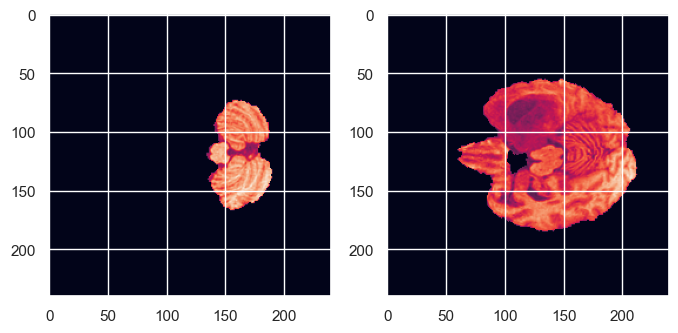

In [153]:
# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [154]:
import csv

def col_and_eval(ch_ft = []):
    id_list2 = []
    csv_filename = r'C:\Users\HP\OneDrive\Desktop\BTP\results.csv'
    dt =[]
    jj = [] #key_list
    id_tp = 0
    row_cc = 0
    row2 = {}
    id_check = {}
    with open(csv_filename) as f:
        reader = csv.DictReader(f)
        for row in reader:
            # if row_cc > 20:
            #     break
            # row_cc += 1
            dt_tp = row
            if row['Patient_ID'] not in id_check:
                id_check[row['Patient_ID']] = 0
            id_check[row['Patient_ID']] += 1
            if len(id_list2) != 0:
                if id_list2[-1] == row["Patient_ID"]:
                    id_tp += 1
                else:
                    dt.append(row2)
                    row2 = {}
                    id_tp = 0
            if id_tp == 0:
                id_list2.append(row["Patient_ID"])
            if len(id_list2) == 1:
                for keysj in row:
                    if keysj != None:
                        if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                            continue
                        # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                        row[keysj] = eval(row[keysj])
                        if isinstance(row[keysj],tuple):
                            ct = 0
                            for it in row[keysj]:
                                keysjn = keysj + str(ct)
                                keysjn += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                if (keysjn in ch_ft) or (len(ch_ft) == 0):
                                    jj.append(keysjn)
                                ct += 1
                            continue
                        keysj += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                        if (keysj in ch_ft) or (len(ch_ft) == 0):
                            jj.append(keysj)
            for keysj in row:
                if keysj != None:
                    if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                        continue
                    # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                    row[keysj] = eval(str(row[keysj]))
                    keys2j = keysj + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                    if isinstance(row[keysj],tuple):
                        ct = 0
                        for it in row[keysj]:
                            keys2j =  keysj + str(ct) + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                            row2[keys2j] = it
                            ct += 1
                        continue
                    row2[keys2j] = row[keysj]
            row2['Patient_ID'] = row['Patient_ID']
    dt.append(row2)
    return dt, jj

# print(jj)
# print(dt)
# create only age: category data


In [155]:
# id: age, categories
def getListAgeDays(id_list, dt, jj, ch_ft = []):
    x_val = []
    y_val = []
    for i in dt:
        if (i["Patient_ID"] not in age_dict):
            # print(i["Patient_ID"])
            continue
        # if (i not in id_list2):
        #     continue
        # masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii.gz').get_fdata())
        # brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii.gz').get_fdata())
        # masks[1] = masks[1]/brain_vol
        # masks[2] = masks[2]/brain_vol
        # masks[3] = masks[3]/brain_vol
        # merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        # ft = dt[]
        j = [age_dict[i["Patient_ID"]]]
        for keysj in i:
            if keysj != None:
                if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                    continue
                if (keysj not in ch_ft) and (len(ch_ft) != 0):
                    continue
                # if(i[keysj][0]=='('):
                #     i[keysj] = tuple(i[keysj])
                # else:
                # print(i[keysj])
                # i[keysj] = eval(i[keysj])
                # if isinstance(i[keysj],tuple):
                #     ct = 0
                #     for it in i[keysj]:
                #         keysjn = keysj + str(ct)
                #         j.append(it)
                #         ct += 1
                #     continue
                j.append(i[keysj])
        # print(j)
        x_val.append(j) 
        if (days_dict[i["Patient_ID"]] < 250):
            y_val.append(0)
        elif (days_dict[i["Patient_ID"]] >= 250 and days_dict[i["Patient_ID"]] < 450):
            y_val.append(1)
        else:
            y_val.append(2)
            
    return np.array(x_val), np.array(y_val)

dt, jj = col_and_eval()
X_all, y_all = getListAgeDays(train_and_test_ids,dt,jj)
print(len(train_and_test_ids))
print(X_all.shape)
print(y_all.shape)
print(f'X_all: {X_all.shape}')
columns = ["age"]+jj+["prediction"]
print(columns)
dfn = np.concatenate((X_all, y_all[:,None]), axis=1)
print(dfn.shape,len(columns))
df = pd.DataFrame(dfn, columns = columns)
df.head()

368
(117, 10701)
(117,)
X_all: (117, 10701)
['age', 'original_shape_Elongation_flair', 'original_shape_Flatness_flair', 'original_shape_LeastAxisLength_flair', 'original_shape_MajorAxisLength_flair', 'original_shape_Maximum2DDiameterColumn_flair', 'original_shape_Maximum2DDiameterRow_flair', 'original_shape_Maximum2DDiameterSlice_flair', 'original_shape_Maximum3DDiameter_flair', 'original_shape_MeshVolume_flair', 'original_shape_MinorAxisLength_flair', 'original_shape_Sphericity_flair', 'original_shape_SurfaceArea_flair', 'original_shape_SurfaceVolumeRatio_flair', 'original_shape_VoxelVolume_flair', 'original_firstorder_10Percentile_flair', 'original_firstorder_90Percentile_flair', 'original_firstorder_Energy_flair', 'original_firstorder_Entropy_flair', 'original_firstorder_InterquartileRange_flair', 'original_firstorder_Kurtosis_flair', 'original_firstorder_Maximum_flair', 'original_firstorder_MeanAbsoluteDeviation_flair', 'original_firstorder_Mean_flair', 'original_firstorder_Median_

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2,prediction
0,60.463,0.731829,0.419790,21.139285,50.356792,50.358713,59.539903,50.990195,63.859220,15226.333330,...,0.379267,3.133984,0.002202,6.177746e+06,0.0,1000000.0,0.0,0.0,0.0,1.0
1,52.263,0.805201,0.596898,17.919111,30.020387,34.132096,34.525353,31.144823,35.496479,9073.541667,...,0.155282,3.169925,0.000983,8.108983e+06,0.0,1000000.0,0.0,0.0,0.0,2.0
2,54.301,0.768372,0.722447,11.550058,15.987407,18.681542,18.384776,18.681542,22.135944,684.083333,...,0.298127,2.521641,0.009550,5.140249e+04,0.0,1000000.0,0.0,0.0,0.0,2.0
3,39.068,0.880563,0.556199,21.603687,38.841633,42.720019,46.238512,44.384682,46.914816,10608.041670,...,0.360428,3.230669,0.003394,2.935966e+06,0.0,1000000.0,0.0,0.0,0.0,2.0
4,68.493,0.342747,0.309231,20.046940,64.828365,60.605280,32.280025,48.754487,61.432890,3209.833333,...,0.582357,2.332735,0.010210,2.073845e+05,0.0,1000000.0,0.0,0.0,0.0,2.0


In [156]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

df = pd.DataFrame(X_all, columns = ["age"]+jj)
display(df)

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,0.554919,0.656126,0.400763,0.460101,0.317408,0.396533,0.524909,0.367734,0.416847,0.278824,...,0.442478,0.442478,0.808517,0.015507,0.044075,0.0,0.0,0.0,0.0,0.0
1,0.415561,0.756109,0.641463,0.373744,0.145977,0.218869,0.264822,0.180164,0.174373,0.165721,...,0.181163,0.181163,0.817790,0.006531,0.057853,0.0,0.0,0.0,0.0,0.0
2,0.450196,0.705924,0.812091,0.202941,0.027683,0.049702,0.097002,0.062366,0.060153,0.011503,...,0.347815,0.347815,0.650543,0.069606,0.000367,0.0,0.0,0.0,0.0,0.0
3,0.191312,0.858806,0.586151,0.472555,0.220338,0.312898,0.386609,0.305301,0.271989,0.193929,...,0.420499,0.420499,0.833461,0.024284,0.020946,0.0,0.0,0.0,0.0,0.0
4,0.691389,0.125925,0.250507,0.430807,0.439399,0.508723,0.241476,0.346603,0.396104,0.057932,...,0.679416,0.679416,0.601808,0.074465,0.001480,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.377101,0.522913,0.462942,0.439761,0.261957,0.340893,0.343034,0.328509,0.281444,0.231966,...,0.244624,0.244624,0.599020,0.002183,0.184846,0.0,0.0,0.0,0.0,0.0
113,0.496066,0.492875,0.525156,0.613237,0.335562,0.368537,0.511492,0.397405,0.392684,0.434804,...,0.397367,0.397367,0.795895,0.003304,0.285056,0.0,0.0,0.0,0.0,0.0
114,0.750990,0.430218,0.363035,0.235926,0.167720,0.109978,0.375000,0.303380,0.330815,0.069622,...,0.169697,0.169697,0.709456,0.014338,0.011361,0.0,0.0,0.0,0.0,0.0
115,0.360106,0.380998,0.381256,0.314331,0.219420,0.247746,0.281452,0.158585,0.252184,0.021592,...,0.323629,0.323629,0.780961,0.060143,0.000326,0.0,0.0,0.0,0.0,0.0


In [157]:
sns.set()

df = pd.DataFrame(X_all, columns = ["age normalised"]+jj)
# sns.pairplot(df, diag_kind='kde')
df.head()

,age normalised,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,0.554919,0.656126,0.400763,0.460101,0.317408,0.396533,0.524909,0.367734,0.416847,0.278824,...,0.442478,0.442478,0.808517,0.015507,0.044075,0.0,0.0,0.0,0.0,0.0
1,0.415561,0.756109,0.641463,0.373744,0.145977,0.218869,0.264822,0.180164,0.174373,0.165721,...,0.181163,0.181163,0.817790,0.006531,0.057853,0.0,0.0,0.0,0.0,0.0
2,0.450196,0.705924,0.812091,0.202941,0.027683,0.049702,0.097002,0.062366,0.060153,0.011503,...,0.347815,0.347815,0.650543,0.069606,0.000367,0.0,0.0,0.0,0.0,0.0
3,0.191312,0.858806,0.586151,0.472555,0.220338,0.312898,0.386609,0.305301,0.271989,0.193929,...,0.420499,0.420499,0.833461,0.024284,0.020946,0.0,0.0,0.0,0.0,0.0
4,0.691389,0.125925,0.250507,0.430807,0.439399,0.508723,0.241476,0.346603,0.396104,0.057932,...,0.679416,0.679416,0.601808,0.074465,0.001480,0.0,0.0,0.0,0.0,0.0


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (93, 10701)
x_test shape: (24, 10701)
y_train shape: (93,)
y_test shape: (24,)


In [159]:
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
%matplotlib inline

print(X_train.shape,y_train.shape)
_ranks = fisher_score.fisher_score(X_train,y_train)

(93, 10701) (93,)


In [188]:
ft_sc = {}
ii = 0
columns = ["age"]+jj
for it in columns[:-1]:
    ft_sc[it] = _ranks[ii]
    ii += 1

sorted_ft_sc = sorted(ft_sc.items(), key=lambda x:x[1], reverse=True)
sorted_ft_sc = dict(sorted_ft_sc)
print(sorted_ft_sc)

{'age': 10700, 'getSquareImage_0_original_glcm_ClusterTendency_t1ce': 10699, 'getLoGImage_5.0_original_glszm_LargeAreaHighGrayLevelEmphasis_t1ce': 10696, 'getWaveletImage_5_original_firstorder_90Percentile_flair': 10694, 'getLoGImage_3.5_original_shape_MinorAxisLength_flair': 10693, 'getSquareImage_0_original_glcm_JointEnergy_flair': 10692, 'getWaveletImage_5_original_glrlm_GrayLevelVariance_t1ce': 10687, 'getLoGImage_2.5_original_glrlm_RunLengthNonUniformityNormalized_t1': 10641, 'getLoGImage_3.0_original_firstorder_Median_t2': 10640, 'getLoGImage_3.0_original_shape_LeastAxisLength_t1': 10632, 'getWaveletImage_7_original_firstorder_Mean_t2': 10619, 'getLoGImage_5.0_original_ngtdm_Coarseness_t2': 10603, 'getLoGImage_5.0_original_gldm_SmallDependenceHighGrayLevelEmphasis_t1': 10599, 'getWaveletImage_7_original_glrlm_RunPercentage_t1': 10596, 'original_shape_Maximum3DDiameter_t1ce': 10594, 'getLoGImage_1.0_original_glrlm_ShortRunLowGrayLevelEmphasis_flair': 10593, 'getExponentialImage_0_

In [161]:
ij = 0
chosen_ft = {}
for it in sorted_ft_sc:
    chosen_ft[it] = sorted_ft_sc[it]
    ij += 1
    if ij>=2000:
        break


In [162]:
dt, jj = col_and_eval(chosen_ft)

In [163]:
ch_X_all, ch_y_all = getListAgeDays(train_and_test_ids,dt,jj,ch_ft=chosen_ft)
print(len(train_and_test_ids))
print(ch_X_all.shape)
print(ch_y_all.shape)
print(f'X_all: {ch_X_all.shape}')
columns = ["age"]+jj+["prediction"]
print(columns)
ch_dfn = np.concatenate((ch_X_all, ch_y_all[:,None]), axis=1)
print(ch_dfn.shape,len(columns))
df = pd.DataFrame(ch_dfn, columns = columns)
df.head()

368
(117, 2000)
(117,)
X_all: (117, 2000)
['age', 'original_firstorder_TotalEnergy_flair', 'original_glcm_Idmn_flair', 'original_glcm_MaximumProbability_flair', 'original_gldm_LowGrayLevelEmphasis_flair', 'original_gldm_SmallDependenceHighGrayLevelEmphasis_flair', 'original_glrlm_GrayLevelVariance_flair', 'original_glrlm_LongRunHighGrayLevelEmphasis_flair', 'original_glszm_HighGrayLevelZoneEmphasis_flair', 'original_glszm_LowGrayLevelZoneEmphasis_flair', 'original_glszm_ZonePercentage_flair', 'original_glszm_ZoneVariance_flair', 'getLoGImage_5.0_original_shape_MajorAxisLength_flair', 'getLoGImage_5.0_original_shape_Maximum2DDiameterRow_flair', 'getLoGImage_5.0_original_shape_Maximum2DDiameterSlice_flair', 'getLoGImage_5.0_original_firstorder_10Percentile_flair', 'getLoGImage_5.0_original_firstorder_Energy_flair', 'getLoGImage_5.0_original_firstorder_MeanAbsoluteDeviation_flair', 'getLoGImage_5.0_original_firstorder_Mean_flair', 'getLoGImage_5.0_original_firstorder_RootMeanSquared_flair

,age,original_firstorder_TotalEnergy_flair,original_glcm_Idmn_flair,original_glcm_MaximumProbability_flair,original_gldm_LowGrayLevelEmphasis_flair,original_gldm_SmallDependenceHighGrayLevelEmphasis_flair,original_glrlm_GrayLevelVariance_flair,original_glrlm_LongRunHighGrayLevelEmphasis_flair,original_glszm_HighGrayLevelZoneEmphasis_flair,original_glszm_LowGrayLevelZoneEmphasis_flair,...,getExponentialImage_0_original_gldm_HighGrayLevelEmphasis_t2,getExponentialImage_0_original_gldm_SmallDependenceEmphasis_t2,getExponentialImage_0_original_glrlm_LowGrayLevelRunEmphasis_t2,getExponentialImage_0_original_glrlm_ShortRunEmphasis_t2,getExponentialImage_0_original_glszm_LargeAreaHighGrayLevelEmphasis_t2,getExponentialImage_0_original_glszm_LargeAreaLowGrayLevelEmphasis_t2,getGradientImage_0_original_shape_SurfaceArea_t2,getGradientImage_0_original_shape_VoxelVolume_t2,getGradientImage_0_original_glcm_Contrast_t2,prediction
0,60.463,1.097421e+09,0.994543,0.090522,0.021394,3.467811,5.242783,229.602334,78.017945,0.025907,...,4.733277,0.016431,0.375413,0.552331,1899946.430,124426.71700,8899.775397,15443.0,0.152263,1.0
1,52.263,1.779964e+09,0.993228,0.064207,0.014669,21.819512,13.717151,220.716094,218.376399,0.011227,...,6.669651,0.015037,0.290514,0.535263,1824796.341,76279.45169,2879.455924,9160.0,0.512227,2.0
2,54.301,1.395407e+08,0.973686,0.276687,0.163082,0.784874,0.751200,24.366822,11.857143,0.197392,...,1.016371,0.015034,0.989905,0.512024,43134.100,43131.85000,924.196735,733.0,0.016111,2.0
3,39.068,1.103482e+09,0.994331,0.071663,0.012672,12.173802,7.067706,231.040504,129.465116,0.014433,...,2.180150,0.012999,0.768172,0.510081,1089761.837,572529.11760,9488.192833,10902.0,0.454496,2.0
4,68.493,4.308820e+08,0.991005,0.040833,0.012868,20.800077,10.378265,209.322448,110.313513,0.018301,...,1.059603,0.019284,0.974544,0.571250,148070.902,148017.08930,5233.470765,3624.0,0.550861,2.0


In [164]:
scaler = MinMaxScaler()
v = ch_X_all
v_scaled = scaler.fit_transform(v)
ch_X_all = v_scaled

df = pd.DataFrame(ch_X_all, columns = ["age"]+jj)
display(df)

,age,original_firstorder_TotalEnergy_flair,original_glcm_Idmn_flair,original_glcm_MaximumProbability_flair,original_gldm_LowGrayLevelEmphasis_flair,original_gldm_SmallDependenceHighGrayLevelEmphasis_flair,original_glrlm_GrayLevelVariance_flair,original_glrlm_LongRunHighGrayLevelEmphasis_flair,original_glszm_HighGrayLevelZoneEmphasis_flair,original_glszm_LowGrayLevelZoneEmphasis_flair,...,getExponentialImage_0_original_gldm_GrayLevelVariance_t2,getExponentialImage_0_original_gldm_HighGrayLevelEmphasis_t2,getExponentialImage_0_original_gldm_SmallDependenceEmphasis_t2,getExponentialImage_0_original_glrlm_LowGrayLevelRunEmphasis_t2,getExponentialImage_0_original_glrlm_ShortRunEmphasis_t2,getExponentialImage_0_original_glszm_LargeAreaHighGrayLevelEmphasis_t2,getExponentialImage_0_original_glszm_LargeAreaLowGrayLevelEmphasis_t2,getGradientImage_0_original_shape_SurfaceArea_t2,getGradientImage_0_original_shape_VoxelVolume_t2,getGradientImage_0_original_glcm_Contrast_t2
0,0.554919,0.011857,0.848475,0.243530,0.127317,0.006793,0.029215,0.074239,0.034014,0.127998,...,0.001082,0.002421,0.045374,0.368502,0.483515,0.030070,1.969639e-03,0.386828,0.280596,0.001553
1,0.415561,0.019299,0.798550,0.165147,0.085894,0.046345,0.084337,0.071025,0.106174,0.053354,...,0.001723,0.003676,0.040801,0.282665,0.460928,0.028881,1.207480e-03,0.119833,0.165796,0.005658
2,0.450196,0.001412,0.056595,0.798054,1.000000,0.001010,0.000000,0.000000,0.000000,1.000000,...,0.000013,0.000011,0.040791,0.989794,0.430174,0.000677,6.827616e-04,0.033119,0.011822,0.000000
3,0.191312,0.011923,0.840418,0.187356,0.073599,0.025556,0.041086,0.074759,0.060464,0.069653,...,0.000697,0.000765,0.034121,0.765607,0.427602,0.017245,9.062985e-03,0.412923,0.197625,0.005000
4,0.691389,0.004589,0.714149,0.095523,0.074803,0.044148,0.062619,0.066903,0.050618,0.089322,...,0.000049,0.000039,0.054726,0.974263,0.508553,0.002338,2.343068e-03,0.224231,0.064645,0.006098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.377101,0.013300,0.701515,1.000000,0.475313,0.000000,0.000143,0.033142,0.002762,0.748896,...,0.000657,0.001279,0.011146,0.569429,0.254794,0.121151,1.775644e-02,0.257988,0.231555,0.005368
113,0.496066,0.053910,0.978316,0.348016,0.038208,0.009798,0.054642,0.328474,0.079295,0.064280,...,0.179454,0.107908,0.281203,0.094877,0.826427,0.004029,9.848307e-05,0.383955,0.434880,0.009117
114,0.750990,0.002668,0.820231,0.658545,0.753306,0.000456,0.010431,0.019199,0.010585,0.503812,...,0.198290,0.240119,0.724977,0.014491,0.979808,0.000413,3.178591e-08,0.084903,0.069980,0.018170
115,0.360106,0.021797,0.810127,0.023170,0.009280,0.676230,0.381657,0.546566,0.563219,0.019136,...,0.003437,0.003384,0.085833,0.359618,0.599784,0.000440,4.800528e-05,0.064500,0.022748,0.330224


In [165]:
sns.set()

df = pd.DataFrame(ch_X_all, columns = ["age normalised"]+jj)
# sns.pairplot(df, diag_kind='kde')
df.head()

,age normalised,original_firstorder_TotalEnergy_flair,original_glcm_Idmn_flair,original_glcm_MaximumProbability_flair,original_gldm_LowGrayLevelEmphasis_flair,original_gldm_SmallDependenceHighGrayLevelEmphasis_flair,original_glrlm_GrayLevelVariance_flair,original_glrlm_LongRunHighGrayLevelEmphasis_flair,original_glszm_HighGrayLevelZoneEmphasis_flair,original_glszm_LowGrayLevelZoneEmphasis_flair,...,getExponentialImage_0_original_gldm_GrayLevelVariance_t2,getExponentialImage_0_original_gldm_HighGrayLevelEmphasis_t2,getExponentialImage_0_original_gldm_SmallDependenceEmphasis_t2,getExponentialImage_0_original_glrlm_LowGrayLevelRunEmphasis_t2,getExponentialImage_0_original_glrlm_ShortRunEmphasis_t2,getExponentialImage_0_original_glszm_LargeAreaHighGrayLevelEmphasis_t2,getExponentialImage_0_original_glszm_LargeAreaLowGrayLevelEmphasis_t2,getGradientImage_0_original_shape_SurfaceArea_t2,getGradientImage_0_original_shape_VoxelVolume_t2,getGradientImage_0_original_glcm_Contrast_t2
0,0.554919,0.011857,0.848475,0.243530,0.127317,0.006793,0.029215,0.074239,0.034014,0.127998,...,0.001082,0.002421,0.045374,0.368502,0.483515,0.030070,0.001970,0.386828,0.280596,0.001553
1,0.415561,0.019299,0.798550,0.165147,0.085894,0.046345,0.084337,0.071025,0.106174,0.053354,...,0.001723,0.003676,0.040801,0.282665,0.460928,0.028881,0.001207,0.119833,0.165796,0.005658
2,0.450196,0.001412,0.056595,0.798054,1.000000,0.001010,0.000000,0.000000,0.000000,1.000000,...,0.000013,0.000011,0.040791,0.989794,0.430174,0.000677,0.000683,0.033119,0.011822,0.000000
3,0.191312,0.011923,0.840418,0.187356,0.073599,0.025556,0.041086,0.074759,0.060464,0.069653,...,0.000697,0.000765,0.034121,0.765607,0.427602,0.017245,0.009063,0.412923,0.197625,0.005000
4,0.691389,0.004589,0.714149,0.095523,0.074803,0.044148,0.062619,0.066903,0.050618,0.089322,...,0.000049,0.000039,0.054726,0.974263,0.508553,0.002338,0.002343,0.224231,0.064645,0.006098


In [171]:
X_train, X_test, y_train, y_test = train_test_split(ch_X_all,ch_y_all,test_size = 0.2, random_state = 42, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (93, 2000)
x_test shape: (24, 2000)
y_train shape: (93,)
y_test shape: (24,)


In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# n_estimators = [1,3,5,10,30,50,100,300]
rfc = RandomForestClassifier(n_estimators = 200)
selector = RFE(rfc, n_features_to_select=400, step=1, verbose=1)

# fit the model to the training set
selector = selector.fit(X_train, y_train)
# y_pred = rfc.predict(X_test)

# print(f'Model accuracy score with {est} decision-trees : {accuracy_score(y_test, y_pred)}')

print(selector.support_)

    # accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
    # acc.append(accuracies)

    # print("Cross validation: Train Score:",np.mean(accuracies))
    # print("Cross validation: Test Score:",rfc.score(X_test,y_test))

Fitting estimator with 2000 features.
Fitting estimator with 1999 features.
Fitting estimator with 1998 features.
Fitting estimator with 1997 features.
Fitting estimator with 1996 features.
Fitting estimator with 1995 features.
Fitting estimator with 1994 features.
Fitting estimator with 1993 features.
Fitting estimator with 1992 features.
Fitting estimator with 1991 features.
Fitting estimator with 1990 features.
Fitting estimator with 1989 features.
Fitting estimator with 1988 features.
Fitting estimator with 1987 features.
Fitting estimator with 1986 features.
Fitting estimator with 1985 features.
Fitting estimator with 1984 features.
Fitting estimator with 1983 features.
Fitting estimator with 1982 features.
Fitting estimator with 1981 features.
Fitting estimator with 1980 features.
Fitting estimator with 1979 features.
Fitting estimator with 1978 features.
Fitting estimator with 1977 features.
Fitting estimator with 1976 features.
Fitting estimator with 1975 features.
Fitting esti

In [179]:
def prune(X):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if selector.support_[iter]:
                xxtp.append(col)
            iter += 1
        xx.append(xxtp)
    return xx

X_train = np.array(prune(X_train))
X_test = np.array(prune(X_test))

print(X_train.shape)

(93, 400)


In [180]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [181]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [182]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 30,
 'bootstrap': True}

In [185]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 5],
    'max_depth': [30,50,60],
    'n_estimators': [100, 200, 300, 400],
    'bootstrap': [True]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [30, 50, 60],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 200, 300, 400]},
             verbose=4)

In [186]:
grid_search.best_params_


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 100}

In [1]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    return classification_report(test_labels,predictions),predictions


In [2]:
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy,y_pred = evaluate(best_grid, X_test, y_test)
print(grid_accuracy)

NameError: name 'grid_search' is not defined

In [ ]:
# sns.barplot(x=feature_scores, y=feature_scores.index)
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")
# plt.show()

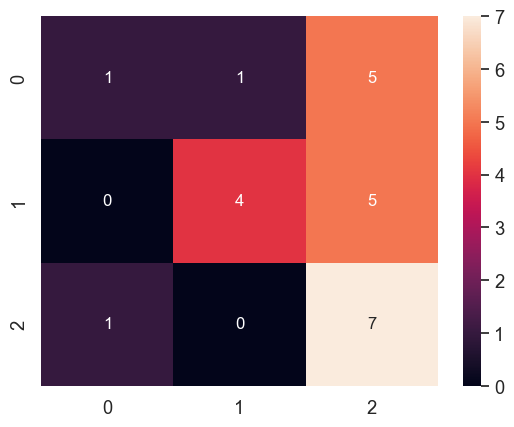

In [ ]:
from sklearn.metrics import confusion_matrix

# np.reshape(y_test,(-1,1))
# np.reshape(y_train,(-1,1))
# print(np.shape(y_pred),np.shape(y_test))
def oec(y_test):
    _y_t = []
    for it1 in y_test:
        if it1 == 0:
            _y_t.append([1,0,0])
        elif it1 == 1:
            _y_t.append([0,1,0])
        else:
            _y_t.append([0,0,1])
    return _y_t

_y_t = np.array(oec(y_test))
_y_p = np.array(oec(y_pred))

cm = confusion_matrix(_y_t.argmax(axis=1), _y_p.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.40      0.44      0.42         9
           2       0.50      0.62      0.56         8

    accuracy                           0.46        24
   macro avg       0.47      0.45      0.45        24
weighted avg       0.46      0.46      0.45        24



In [ ]:
grid = {
    'n_estimators':np.arange(1,100,1),
    'criterion':['gini','entropy']
    }

rfc_ = RandomForestClassifier(random_state = 42)
rf_grid = GridSearchCV(rfc_, grid, cv=5)
rf_grid.fit(X_train,y_train)

print("Hyperparameters:",rf_grid.best_params_)
print("Train Score:", rf_grid.best_score_)
print("Test Score:",rf_grid.score(X_test,y_test))

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_estimators = [1,3,5,10,30,50,100,300]
acc = []
for est in n_estimators:
    rfc = RandomForestClassifier(n_estimators=est, random_state=0)

    # fit the model to the training set
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)

    print(f'Model accuracy score with {est} decision-trees : {accuracy_score(y_test, y_pred)}')



    accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
    acc.append(accuracies)

    print("Cross validation: Train Score:",np.mean(accuracies))
    print("Cross validation: Test Score:",rfc.score(X_test,y_test))

Model accuracy score with 1 decision-trees : 0.3333333333333333
Cross validation: Train Score: 0.3655913978494623
Cross validation: Test Score: 0.3333333333333333
Model accuracy score with 3 decision-trees : 0.3333333333333333
Cross validation: Train Score: 0.2903225806451613
Cross validation: Test Score: 0.3333333333333333
Model accuracy score with 5 decision-trees : 0.3333333333333333
Cross validation: Train Score: 0.3548387096774193
Cross validation: Test Score: 0.3333333333333333
Model accuracy score with 10 decision-trees : 0.4583333333333333
Cross validation: Train Score: 0.3118279569892473
Cross validation: Test Score: 0.4583333333333333
Model accuracy score with 30 decision-trees : 0.4583333333333333
Cross validation: Train Score: 0.3763440860215053
Cross validation: Test Score: 0.4583333333333333
Model accuracy score with 50 decision-trees : 0.4166666666666667
Cross validation: Train Score: 0.40860215053763443
Cross validation: Test Score: 0.4166666666666667
Model accuracy sco

In [115]:
df = pd.DataFrame(X_train, columns = ["age"]+jj)

feature_scores = pd.Series(rfc.feature_importances_, index=df.columns).sort_values(ascending=False)
feature_scores

age                                                             0.013386
getLoGImage_2.5_original_glcm_ClusterShade_t2                   0.008502
getLoGImage_3.0_original_glcm_Idm_t2                            0.004663
getLoGImage_3.0_original_glcm_ClusterShade_t2                   0.004014
original_shape_Elongation_flair                                 0.003655
                                                                  ...   
getLBP2DImage_0_original_firstorder_Minimum_flair               0.000000
getWaveletImage_2_original_glszm_GrayLevelNonUniformity_t1ce    0.000000
getLBP2DImage_0_original_firstorder_Range_flair                 0.000000
getLBP2DImage_0_original_glcm_Correlation_flair                 0.000000
getLBP2DImage_0_original_glcm_MaximumProbability_t1ce           0.000000
Length: 1001, dtype: float64

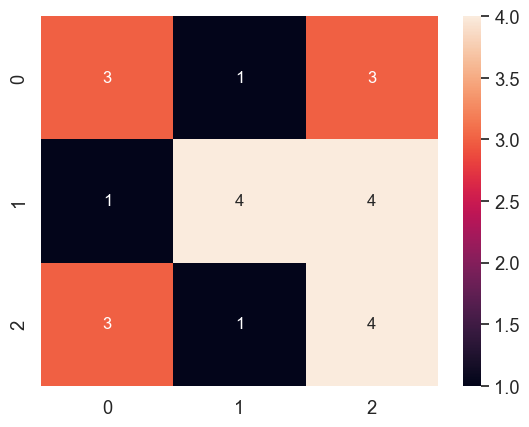

In [116]:
from sklearn.metrics import confusion_matrix

# np.reshape(y_test,(-1,1))
# np.reshape(y_train,(-1,1))
# print(np.shape(y_pred),np.shape(y_test))
def oec(y_test):
    _y_t = []
    for it1 in y_test:
        if it1 == 0:
            _y_t.append([1,0,0])
        elif it1 == 1:
            _y_t.append([0,1,0])
        else:
            _y_t.append([0,0,1])
    return _y_t

_y_t = np.array(oec(y_test))
_y_p = np.array(oec(y_pred))

cm = confusion_matrix(_y_t.argmax(axis=1), _y_p.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [117]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.67      0.44      0.53         9
           2       0.36      0.50      0.42         8

    accuracy                           0.46        24
   macro avg       0.49      0.46      0.46        24
weighted avg       0.50      0.46      0.47        24

